# Mémoire de groupe de travail dans WebGPU (Workgroup memory in webGPU)

- var<workgroup>
- un espace mémoire partagé entre tous les `threads` dans le même groupe de travail
- beaucoup plus rapide que les tampons (zone de mémoire temporaire) globaux/stockage
- comparable à :
    - CUDA: __shared__
    - OpenCL : __local
    - HLSL : groupshared

Pourquoi utiliser la mémoire de groupe de trvail? 

- avantages :
    - `Faible latence` par rapport à la mémoire global
    - Permet aux threads de collaborer efficacement
    - Empêche les lectures répétées de la mémoire lente de l'appareil


### Flux de travail typique

1) Threads charge les données dans la mémoire du groupe de travail

2) Effectuer le calcul collaboratif

3) Rédigez les résultats à la mémoire globale


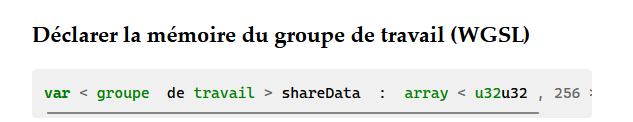

- Alloué une fois par groupe de travail
- Accessible à tous les threads du groupe
- Durée de vie = durée de l'envoi de shader de calcul
- Programmeur doit assurer la synchronisation
(Tous les threads d'un groupe de travail peuvent ne pas s'exécuter simultanément)



In [2]:
from timeit import main
import numpy as np
import wgpu

# Initialize WebGPU
adapter = wgpu.gpu.request_adapter_sync(
    canvas=None, power_preference="high-performance"
)
device = adapter.request_device_sync()
queue = device.queue

# Create input data
N = 1024  # Must be divisible by workgroup size (e.g., 64)
data = np.arange(1, N + 1, dtype=np.uint32)  # sum = 1024 * 1025 / 2 = 524800

# Create buffer for input data
input_buffer = device.create_buffer_with_data(
    data=data, usage=wgpu.BufferUsage.STORAGE
)

# Create buffer to store partial sums (one per workgroup)
num_groups = N // 128  # workgroup_size = 64 car on travaille avec 128
partial_sums_buffer = device.create_buffer(
    size=num_groups * 4,
    usage=wgpu.BufferUsage.STORAGE
    | wgpu.BufferUsage.COPY_SRC,
)

# Shader code: parallel reduction with workgroup shared memory
with open('shader.wgsl') as file:
    shader_code = file.read()

# Create the shader module
shader_module = device.create_shader_module(code=shader_code)

# Bind group layout and pipeline
bgl = device.create_bind_group_layout(
    entries=[
        {
            "binding": 0,
            "visibility": wgpu.ShaderStage.COMPUTE,
            "buffer": {"type": "read-only-storage"},
        },
        {
            "binding": 1,
            "visibility": wgpu.ShaderStage.COMPUTE,
            "buffer": {"type": "storage"},
        },
    ]
)
pipeline_layout = device.create_pipeline_layout(bind_group_layouts=[bgl])

pipeline = device.create_compute_pipeline(
    layout=pipeline_layout,
    compute={"module": shader_module, "entry_point": "main"},
)

# Create bind group
bind_group = device.create_bind_group(
    layout=bgl,
    entries=[
        {"binding": 0, "resource": {"buffer": input_buffer}},
        {"binding": 1, "resource": {"buffer": partial_sums_buffer}},
    ],
)

# Encode and submit commands
encoder = device.create_command_encoder()
pass_enc = encoder.begin_compute_pass()
pass_enc.set_pipeline(pipeline)
pass_enc.set_bind_group(0, bind_group)
pass_enc.dispatch_workgroups(num_groups)
pass_enc.end()
queue.submit([encoder.finish()])

out: memoryview = device.queue.read_buffer(partial_sums_buffer)# type: ignore
partial_sums = np.frombuffer(out.cast("I"), dtype=np.uint32)
total = np.sum(partial_sums) # final sum on CPU

print(f"Partial sums = {partial_sums}")
print(f"Total = {total}")
print(f"La valeur maximale en collaboration = {max(partial_sums)}")
print(f"Trie =  {sorted(partial_sums)}")




Partial sums = [  8256  24640  41024  57408  73792  90176 106560 122944]
Total = 524800
La valeur maximale en collaboration = 122944
Trie =  [np.uint32(8256), np.uint32(24640), np.uint32(41024), np.uint32(57408), np.uint32(73792), np.uint32(90176), np.uint32(106560), np.uint32(122944)]


In [25]:
a =[  8256,  24640,  41024,  57408,  73792,  90176, 106560, 122944]
print(sum(a))


524800


## choix de la taille du groupe de travail

1) limites de matériels (Hardware limits)
    - max_compute_workgroup_size_x
    - max_compute_invocations_per_workgroup
    - max_compute_workgroup_storage_size

2) Warp/Wavefront Alignment
    - Les GPU exécutent des `threads` dans des groupes de taille fixe:
        - NIVIDIA : 32 threads (warp)
        - AMD : 64 threads (wavefront)

    - Pour éviter l'exécution gaspillée : choisir une taille qui est un `multiple de la taille de la chaîne / front d'onde`

3) Ne pas dépasser la limite de mémoire partagé

4) occupation et performance
    - un très grand groupe de travail :
        - peut ne pas utiliser toutes les unités de calcul
    - un groupe de travail trop petit:
        - chaque unité de calcul n'a pas assez à faire

5) Gammes pratiques typiques:
    - 64 à 256 threads par groupe de travail

6) ajuster experiementalement pour de meilleures performances

